# 주제: CNN을 이용한 Image Classification 구현하고 성능 개선하기

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 import 가능합니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

## 데이터 소개
    - 이번 주제는 Intel image classification dataset을 사용합니다.
    - Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성되어 있습니다.
    - 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
    - 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있습니다.    

    1. seg_train
      - training용 data
      
    2. seg_test
      - test/validation용 data
      - label 있음
      - 이번 실습에서는 validation data로 사용

    3. set_pred
      - test용 data
      - label 없음
      - 이번 실습에서는 사용하지 않음

- 원본 데이터 출처: https://www.kaggle.com/puneet6060/intel-image-classification

## 문제 소개
    - 이번 실습에서는 image classification model을 만들어서 학습하고, 성능을 향상하기 위한 방법들을 찾아서 학습해보도록 하겠습니다.

## 최종 목표    
    - pre-trained CNN 활용 방법 이해
    - CNN의 성능을 올리기 위한 다양한 방법 습득

- 출제자: 이진원 강사

## Step 1. 데이터 다운로드 및 전처리

In [2]:
## library를 import 합니다
## 추가로 필요한 library가 있으면 추가로 import 해도 좋습니다
import os
import numpy as np
import random
from datetime import datetime
import time
import math
# import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [56]:
## Hyper-Parameter 설정
# image resolution
RES = 224
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001

### 문제 1. 데이터 불러오기

    - data는 아래 url(google drive)에 저장되어 있습니다.(tar 파일)
    - gdown library를 이용하여 data를 다운받고, 현재 directory에 tar파일 압축을 풀어줍니다.
    

In [ ]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [4]:
## data download 받기(gdown.download 사용)
##### CODE HERE #####
# gdown.download('url', 'file_name', quiet = False)

!tar -xf ./datasets/intel_image_classification.tar

    - 아래와 같이 train dataset은 train_dir, validation dataset은 val_dir로 경로를 설정합니다

In [57]:
data_dir = "./datasets/"
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [58]:
!ls $train_dir

buildings forest    glacier   mountain  sea       street


### 문제 2. dataset 만들기
    - keras.preprocessing.image_dataset_from_directory를 이용하여 training용 dataset(이름: train_ds), validation용 dataset(이름: val_ds)를 만듭니다.
    - 위 hyperparameter를 참조하여 image_size와 batch_size를 설정합니다.
    - training data는 shuffle=True로 설정합니다.

In [59]:
##### CODE HERE #####

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    image_size = (RES, RES),
    batch_size = N_BATCH 
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle = False,
    image_size = (RES, RES),
    batch_size = N_BATCH 
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


### 문제 3. training data, validation data 갯수 확인
    - 위 dataset 생성시에 나오는 log에서 training data와 validation data의 갯수를 확인하여, 각각 N_TRAIN, N_VAL 변수에 저장합니다.

In [60]:
##### CODE HERE #####

N_TRAIN = 14034
N_VAL = 3000

### 문제 4. class list 만들기
    - class 이름을 저장하고 있는 list를 생성합니다

In [61]:
##### CODE HERE #####

# classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

classes = train_ds.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


    - data 공급 속도를 빠르게 하기 위하여 dataset에 prefetch를 적용합니다

In [62]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

### 문제 5. dataset 확인하기
    - train_ds에서 batch를 5개 읽어와서 각 batch의 첫번째 image를 화면에 출력합니다.
    - 위 class list에서 image에 대한 label을 찾아서 title로 넣습니다.

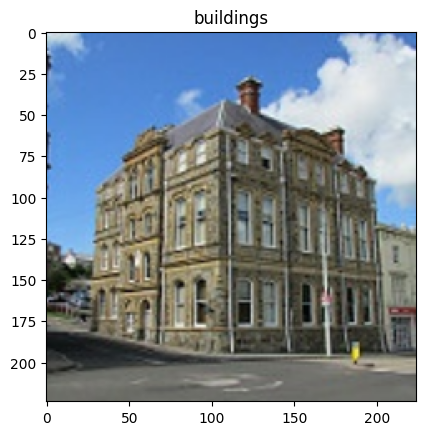

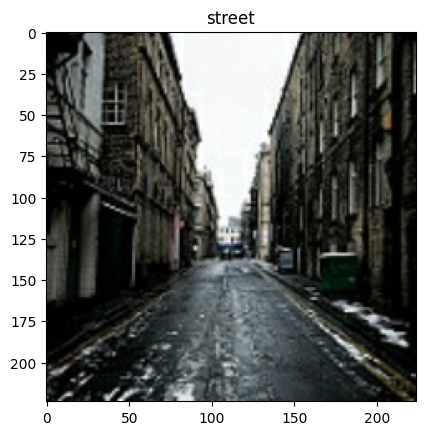

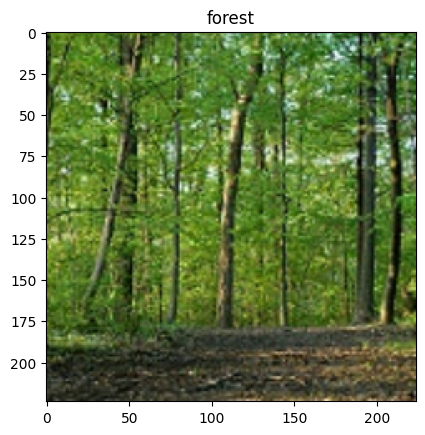

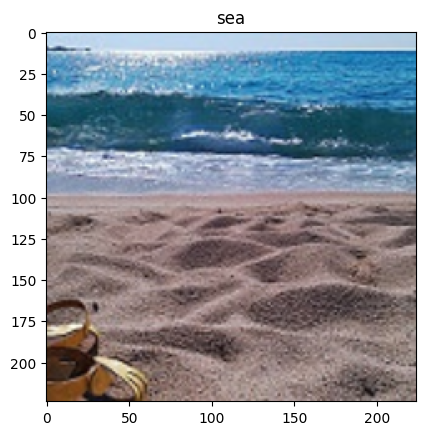

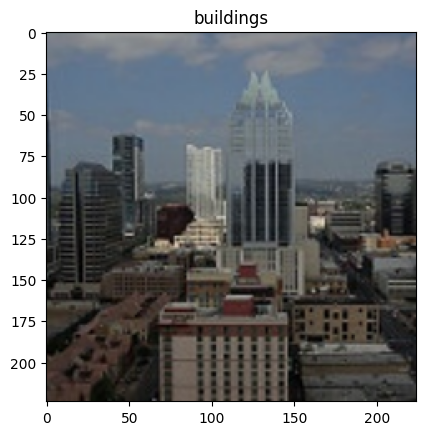

In [63]:
##### CODE HERE #####

# 이미지 강제 resize에 따른
# 인터폴레이션 
# 엑스트라폴레이션
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(classes[labels[0].numpy()])
    plt.show()

## Step 2. Pretrained MobileNetV3로 Training 하기
이번 Step에서는 MobileNetV3를 이용하여 image classification을 학습해보겠습니다.

    - pretrained MobileNetV3는 tensorflow.keras.applications에서 기본으로 제공합니다.
    - 아래와 같이 pretrained MobileNetV3 model을 다운받습니다.
  

In [64]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3)) 

# include_top=False : 마지막 classification 하는 Dense레이어는 불러오지 않음
# imagenet은 class 1000개짜리 문제를 푸는 모델인데 지금은 class 6개만 분류하는거라 따로 만들어야함

In [65]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_10[0][0]']            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_3[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

### 문제 6. Intel image classification을 위한 MobileNetV3 model 만들기    
    - functional API를 활용하여 6개의 class를 classification하는 model을 만들어봅시다.
    - fully connected layer는 1개만 추가하고, batchnorm을 사용합니다.
    - MobileNetV3에 data가 들어가기 전에 preprocess_input을 적용하여 input data가 preprocessing될 수 있도록 합니다.

In [66]:
##### CODE HERE #####

def create_model():
    inputs = keras.Input(shape = (RES, RES, 3))
    x = preprocess_input(inputs)
    x = mobilenetv3(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = N_CLASS)(x)
    x = BatchNormalization()(x)    
    outputs = Softmax()(x)
    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [25]:
model = create_model()

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 3462      
                                                                 
 batch_normalization (Batch  (None, 6)                 24        
 Normalization)                                                  
                                                             

  ### 문제 7. 학습하기
    - SGD를 사용하여 model을 학습합니다.(총 epoch수는 N_EPOCH으로 설정)
    - learning rate은 위에서 정한 hyperparameter(LR)을 사용합니다.
    - loss는 cross entropy를 사용합니다.

In [27]:
##### CODE HERE #####
model.compile(
    # keras.optimizers.SGD(learning_rate=LR), # m1 MAC 에서 느리게 실행됨
    keras.optimizers.legacy.SGD(learning_rate=LR), 
    loss = keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'])

In [28]:
model.fit(train_ds, 
          epochs=N_EPOCH, 
          validation_data=val_ds)

Epoch 1/50


2023-11-07 15:09:02.217373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - ETA: 0s - loss: 2.2084 - accuracy: 0.1516

2023-11-07 15:09:47.057281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - 50s 181ms/step - loss: 2.2084 - accuracy: 0.1516 - val_loss: 1.9633 - val_accuracy: 0.1993
Epoch 2/50
220/220 [==============================] - 34s 155ms/step - loss: 1.9854 - accuracy: 0.2210 - val_loss: 1.7915 - val_accuracy: 0.2793
Epoch 3/50
220/220 [==============================] - 34s 156ms/step - loss: 1.7841 - accuracy: 0.2931 - val_loss: 1.6235 - val_accuracy: 0.3523
Epoch 4/50
220/220 [==============================] - 34s 157ms/step - loss: 1.6227 - accuracy: 0.3559 - val_loss: 1.4848 - val_accuracy: 0.4227
Epoch 5/50
220/220 [==============================] - 34s 155ms/step - loss: 1.4921 - accuracy: 0.4172 - val_loss: 1.3759 - val_accuracy: 0.4813
Epoch 6/50
220/220 [==============================] - 34s 155ms/step - loss: 1.3892 - accuracy: 0.4660 - val_loss: 1.2917 - val_accuracy: 0.5287
Epoch 7/50
220/220 [==============================] - 34s 153ms/step - loss: 1.3081 - accuracy: 0.5108 - val_loss: 1.2258 - val_accuracy: 0.5

### 문제 8. Optimizer 변경하기
    - 같은 model에서 optimizer만 Adam으로 변경하여 학습해봅시다.

In [67]:
##### CODE HERE #####
model = create_model()

In [68]:
model.compile(
    keras.optimizers.Adam(learning_rate=LR), 
    loss = keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'])

In [69]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50


2023-11-07 15:43:37.577792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.7893

2023-11-07 15:44:17.906219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - 47s 184ms/step - loss: 0.8142 - accuracy: 0.7893 - val_loss: 0.7561 - val_accuracy: 0.8593
Epoch 2/50
220/220 [==============================] - 35s 159ms/step - loss: 0.5181 - accuracy: 0.9137 - val_loss: 0.6690 - val_accuracy: 0.8983
Epoch 3/50
220/220 [==============================] - 35s 159ms/step - loss: 0.4611 - accuracy: 0.9286 - val_loss: 0.6009 - val_accuracy: 0.9173
Epoch 4/50
220/220 [==============================] - 36s 161ms/step - loss: 0.4147 - accuracy: 0.9407 - val_loss: 0.5746 - val_accuracy: 0.9187
Epoch 5/50
220/220 [==============================] - 35s 159ms/step - loss: 0.3857 - accuracy: 0.9486 - val_loss: 0.5404 - val_accuracy: 0.9247
Epoch 6/50
220/220 [==============================] - 34s 156ms/step - loss: 0.3594 - accuracy: 0.9570 - val_loss: 0.5152 - val_accuracy: 0.9300
Epoch 7/50
220/220 [==============================] - 35s 160ms/step - loss: 0.3324 - accuracy: 0.9652 - val_loss: 0.4973 - val_accuracy: 0.9

## Step3. Model 성능 올리기

이번 Step에서는 다양한 방법을 사용하여 MobileNetV3의 성능을 올려보도록 하겠습니다.

### 문제 9. Data augmentation 사용하기
    - training data에 data augmentation을 적용해봅시다.
    - dataset을 만들 때 training data를 256x256으로 resize합니다.
    - augmentation function을 만들고, 224x224로 random crop합니다.
    - horizontal flip도 random으로 적용합니다.
    - augmentation을 하였으므로 training epoch을 100으로 키웁니다.
    - optimizer와 다른 hyperparameter는 수정하지 않고 training합니다.

In [70]:
##### CODE HERE #####
RES_BEF = 256
N_EPOCH = 100

In [71]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.


In [72]:
def aug(image, label):
    image = tf.image.random_crop(image, [RES, RES, 3])
    image = tf.image.random_flip_left_right(image)
    return image, label

In [73]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls = AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

In [74]:
model = create_model()
model.compile(
    keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.SparseCategoricalCrossentropy,
    metrics=['accuracy']
)

In [75]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)

Epoch 1/100


TypeError: in user code:

    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/losses.py", line 160, in __call__
        return losses_utils.compute_weighted_loss(
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/utils/losses_utils.py", line 328, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    TypeError: Failed to convert elements of <keras.src.losses.SparseCategoricalCrossentropy object at 0x2ce24e6d0> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.


### 문제 10. cutmix 알고리즘 구현을 위한 dataset 재생성
    - data augmentation 방법 중 하나인 cutmix를 구현해봅시다.
    - 논문은 https://arxiv.org/abs/1905.04899 에서 확인할 수 있습니다.
    - 알고리즘에 대한 간략한 설명은 맨 첫부분에 이론강의로 제공되니, 강의를 시청하고 문제를 푸는 것도 좋습니다.

    - cutmix를 위해서는 사전에 label이 one-hot encoding되어 있어야 하므로, dataset을 수정하여 label이 one-hot이 되도록 합니다.

In [ ]:
##### CODE HERE #####

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

    - 아래 코드를 실행하여 제대로 one-hot encoding이 되어있는지 확인해봅시다

In [ ]:
for images, labels in train_ds.take(1):  
  print(labels[0].numpy())
for images, labels in val_ds.take(1):  
  print(labels[0].numpy())

### 문제 11. cutmix 알고리즘 구현
    - cutmix 알고리즘을 구현해봅시다.
    - cutmix라는 함수를 만들어서 구현합니다.
    - 위에서 생성한 dataset에 map으로 적용할 수 있도록 images, labels를 입력으로 받습니다.

In [ ]:
##### CODE HERE #####

def cutmix(images, labels):
    imgs = []; labs = []
    
    for i in range(N_BATCH):
        APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
        idx = tf.random.uniform((), 0, N_BATCH, tf.int32) # 끼워 넣어 줄 이미지

        W = RES
        H = RES

        lam = tf.random.uniform(())
        cut_ratio = tf.math.sqrt(1. - lam)
        cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
        cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

        cx = tf.random.uniform((), int(W / 8), int(7 / 8*W), tf.int32)
        cy = tf.random.uniform((), int(H / 8), int(7 / 8*H), tf.int32)

        xmin = tf.clip_by_value(cx - cut_w // 2, 0, W)
        ymin = tf.clip_by_value(cy - cut_h // 2, 0, H)
        xmax = tf.clip_by_value(cx + cut_w // 2, 0, W)
        ymax = tf.clip_by_value(cy + cut_h // 2, 0, H)
        
        # (N, H, W, C)
        mid_left = images[i, ymin:ymax, :xmin, :]
        mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
        mid_right = images[i, ymin:ymax, xmax:, :]
        middle = tf.concat([mid_left, mid_mid, mid_right], axis = 1)
        top = images[i, :ymin, :, :]
        bottom = images[i, ymax:, :, :]
        
        new_img = tf.concat([top, middle, bottom], axis = 0)
        imgs.append(new_img)

        cut_w_mod = xmax - xmin
        cut_h_mod = ymax - ymin

        alpha = tf.cast((cut_w_mod * cut_h_mod) / (W * H), tf.float32)
        
        label1 = labels[i]
        label2 = labels[idx]

        new_label = ((1 - alpha) * label1 + alpha * label2)

        labs.append(new_label)

    new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

    return new_imgs, new_labs



### 문제 12. cutmix 적용 및 확인
    - 작성한 cutmix 알고리즘을 train_ds에 적용하고, 문제 5에서와 같이 확인해봅니다.
    - 앞에서 적용했던 random crop과 random flip도 함께 적용합니다.

In [ ]:
##### CODE HERE #####

train_ds = train_ds.unbatch().map(
                                aug, 
                                mum_parallel_calls = AUTOTUNE).batch(
                                                                N_BATCH, 
                                                                drop_remainder = True).map(
                                                                                        cutmix, num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE)

In [ ]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy().astype('uint8'))
    print(labels[0].numpy())
    plt.show()

### 문제 13. cutmix 적용하여 training
    - model을 새로 생성하고 학습하여 결과를 확인해봅시다.
    - 다른 hyperparameter는 이전과 동일하게 하여 결과를 비교해봅시다.

In [ ]:
##### CODE HERE #####
model = create_model()

In [ ]:
model.compile(
    keras.optimizers.Adam(learning_rate=LR),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)

### 문제 14. Bigger resolution
    - input image resolution을 320x320으로 키워봅시다.
    - random crop을 적용하기 전 resolution은 330x330으로 설정합니다.
    - resolution에 맞게 train_ds와 val_ds를 다시 생성하고, data augmentation을 동일하게 적용합니다.

  

In [ ]:
##### CODE HERE #####
## Hyper-Parameter 설정
# image resolution
RES_BEF = 330
RES = 320
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 100
# learning rate
LR = 0.0001

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

In [ ]:
train_ds = train_ds.unbatch().map(
                                aug, 
                                mum_parallel_calls = AUTOTUNE).batch(
                                                                N_BATCH, 
                                                                drop_remainder = True).map(
                                                                                        cutmix, 
                                                                                        num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE)

### 문제 15. Learning rate warmup + cosine decay 구현하기
    - custom learning rate scheduler를 만들어서 warm up과 cosine anealing을 구현해봅시다.
    - max_lr, warmup_steps, decay_steps 세가지 항목을 입력을 받을 수 있도록 합니다. 
    - max_lr은 최대 learning rate, warmup_steps는 warm up이 끝나는 step 수, decay steps는 cosine decay가 끝나는 step 수를 의미합니다.
    - keras.optimizers.schedules.LearningRateSchedule를 상속하여 subclass로 만듭니다.
    - 자세한 사항은 아래 링크들을 참고하시면 됩니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

https://www.tensorflow.org/tutorials/text/transformer

In [ ]:
##### CODE HERE #####
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, warmup_steps, decay_steps):
        super(CustomSchedule, self).__init__()
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps,
        self.decay_steps = decay_steps

    def __call__(self, step):
        lr = tf.cond(step < self.warmup_steps,
                     lambda: self.max_lr / self.warmup_steps * step,
                     lambda: 0.5 * (1 + tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps)) * self.max_lr)
        return lr



### 문제 16. Learning rate scheduling visualization
    - 위에서 작성한 learning rate scheduling class가 제대로 동작하는지 적당한 값을 넣고 graph를 그려서 확인해봅시다.

In [ ]:
##### CODE HERE #####
steps_per_epoch = N_TRAIN // N_BATCH
lr_schedule = CustomSchedule(LR, 5*steps_per_epoch, 200*steps_per_epoch)

lr = []
for step in range(steps_per_epoch * 200):
    lr.append(lr_schedule(step))
step_list = list(np.arange(steps_per_epoch*200) + 1)

plt.plot(step_list, lr)
plt.show()

### 문제 17. Label smoothing 적용하여 학습하기
    - 위에서 새로 적용한 모든 것들(resolution, epoch 수, learning rate scheduling)을 다 반영하고, label smoothing까지 적용하여 학습해봅시다.
    - max_lr은 LR로, warmup_steps는 3 epoch에 해당하는 step수, decay_steps는 N_EPOCH에 해당하는 step수만큼으로 설정합니다.
    - label smoothing 값은 0.1로 설정합니다.

In [ ]:
##### CODE HERE #####
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [ ]:
model = create_model()

In [ ]:
lr_schedule = CustomSchedule(LR, 3*steps_per_epoch, N_EPOCH * steps_per_epoch)
model.compile(keras.optimizers.Adam(lr_schedule),
              loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)

### 문제 18. Learning rate decay(계단식) 적용하여 학습하기
    - 계단식으로 learning rate decay를 적용해봅시다.
    - 매 30 epoch마다 1/10로 learning rate을 decay 시키도록 하여 학습해봅시다.
    - 구현은 keras.optimizers.schedules.ExponentialDecay API를 활용합니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [ ]:
##### CODE HERE #####

model = create_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(LR, 
                                                          steps_per_epoch * 30,
                                                          0.1,
                                                          True)

In [ ]:
model.compile(
    keras.optimizers.Adam(lr_schedule),
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics = ['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)